# 02 — Data Cleaning

This notebook transforms the raw energy dataset into a clean, validated 
dataset ready for EDA and modeling.

**Input:** `data/raw/household_power_consumption.txt`  
**Output:** `data/processed/energy_clean.parquet`

This notebook is organized as follows:
```{mermaid}
flowchart TD
    A[1. Imports and Config] --> B[2. Load Raw Data]
    B --> C[3. Datetime Conversion]
    C --> D[4. Drop Missing Values]
    D --> E[5. Outlier Detection]
    E --> F[6. Time Features]
    F --> G[7. Anomaly Labels]
    G --> H[8. Final Validation]
    H --> I[9. Save Dataset]
    I --> J[10. Summary of Findings]

    style A fill:#1e3a5f,color:#fff
    style B fill:#1e3a5f,color:#fff
    style C fill:#1e3a5f,color:#fff
    style D fill:#1e3a5f,color:#fff
    style E fill:#1e3a5f,color:#fff
    style F fill:#1e3a5f,color:#fff
    style G fill:#1e3a5f,color:#fff
    style H fill:#1e3a5f,color:#fff
    style I fill:#1e3a5f,color:#fff
    style J fill:#2d6a4f,color:#fff
```

> **Goal:** Transform the raw dataset into a clean, validated dataset ready for EDA and modeling.

### Quick Navigation

| Section | Description |
|---|---|
| [1. Imports & Config](#1.-Imports-&-Config) | Load libraries and project configuration |
| [2. Load Raw Data](#2.-Load-Raw-Data) | Read raw dataset from data/raw/ |
| [3. Datetime Conversion](#3.-Combine-Date-&-Time-→-Datetime) | Combine Date & Time into single datetime column |
| [4. Drop Missing Values](#4.-Drop-Missing-Values) | Remove 25,979 MNAR rows from meter outages |
| [5. Outlier Detection](#5.-Outlier-Detection-&-Treatment) | Z-score and IQR methods with visual comparison |
| [6. Time Features](#6.-Extract-Time-Features) | Extract hour, day, month, year, is_weekend |
| [7. Anomaly Labels](#7.-Engineer-Anomaly-Labels) | Engineer Normal / Spike / Fault / Outage labels |
| [8. Final Validation](#8.-Final-Validation) | Shape, dtypes, missing values and class distribution |
| [9. Save Dataset](#9.-Save-Cleaned-Dataset) | Export to data/processed/energy_clean.parquet |
| [10. Summary](#10.-Summary-of-Findings) | Key decisions and agenda for next notebook |

## 1. Imports & Config


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path
from loguru import logger
import yaml
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Plot settings
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 5)

Load configuration file

In [2]:
# Load project config
with open("../configs/config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Define paths
raw_path    = Path("../") / config["paths"]["raw_data"]
output_path = Path("../") / config["paths"]["processed_data"]

logger.info(f"Input:  {raw_path}")
logger.info(f"Output: {output_path}")

2026-02-25 12:54:35.468 | INFO     | __main__:<module>:9 - Input:  ../data/raw/household_power_consumption.txt
2026-02-25 12:54:35.469 | INFO     | __main__:<module>:10 - Output: ../data/processed/energy_clean.parquet


## 2. Load Raw Data


In [3]:
df = pd.read_csv(raw_path, sep=";", na_values=["?"], low_memory=False)
logger.info(f"Dataset loaded succesfully")
logger.info(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

2026-02-25 12:54:36.428 | INFO     | __main__:<module>:2 - Dataset loaded succesfully
2026-02-25 12:54:36.428 | INFO     | __main__:<module>:3 - Shape: 2,075,259 rows × 9 columns


| Column | Type | Unit | Description |
|---|---|---|---|
| Date | object | - | Measurement date |
| Time | object | - | Measurement time (1-min frequency) |
| Global_active_power | float64 | kW | Total active power consumed by the household |
| Global_reactive_power | float64 | kW | Reactive (non-working) power — voltage/current phase offset |
| Voltage | float64 | V | Supply voltage (European standard ~230V) |
| Global_intensity | float64 | A | Average current draw over the minute interval |
| Sub_metering_1 | float64 | Wh | Kitchen appliances (dishwasher, oven, microwave) |
| Sub_metering_2 | float64 | Wh | Laundry room (washer, dryer, fridge) |
| Sub_metering_3 | float64 | Wh | Climate control and water heater |

## 3. Combine Date & Time → Datetime


The raw dataset stores date and time as two separate string columns.
We combine them into a single `datetime` column so we can:
- Sort and index by time
- Extract time features (hour, month, day of week)
- Plot time series correctly
- Perform resampling and rolling operations

In [4]:
# ── 3. Datetime Conversion ─────────────────────────────────────────────────
# WHY: ML models and time series operations require a proper DatetimeIndex.
#      Keeping Date/Time as separate strings prevents resampling, shifting,
#      and any temporal feature extraction.

df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],  # combine Date and Time string columns
    format="%d/%m/%Y %H:%M:%S"      # explicit format is faster than inference (~10x)
)

df = df.drop(columns=["Date", "Time"])
df = df.set_index("datetime")
df = df.sort_index()  # WHY: raw data isn't guaranteed to be chronological

logger.info(f"DatetimeIndex set | range: {df.index.min()} → {df.index.max()} | rows: {len(df):,}")

2026-02-25 12:54:41.248 | INFO     | __main__:<module>:15 - DatetimeIndex set | range: 2006-12-16 17:24:00 → 2010-11-26 21:02:00 | rows: 2,075,259


## 4. Drop Missing Values
From profiling, we found **25,979 missing values** spread equally across all 7 numeric columns — the exact same count in every column points to **simultaneous sensor dropout**, not random missingness.

This classifies as **MNAR (Missing Not At Random)** — the data is missing *because* of a meter outage event. Imputing these values (e.g. forward-fill, mean) would fabricate consumption during a known outage, introducing false signal into the model. The correct strategy is to **drop**.

In [5]:
rows_before = len(df)

df = (df
      .dropna()
      .sort_index())

rows_dropped = rows_before - len(df)

logger.info(
    f"Missing values dropped | "
    f"before: {rows_before:,} | "
    f"after: {len(df):,} | "
    f"dropped: {rows_dropped:,} ({rows_dropped / rows_before:.2%})"
)

2026-02-25 12:54:41.303 | INFO     | __main__:<module>:9 - Missing values dropped | before: 2,075,259 | after: 2,049,280 | dropped: 25,979 (1.25%)


 Metric | Value |
|---|---|
| Rows before | 2,075,259 |
| Rows dropped | 25,979 |
| Rows remaining | 2,049,280 |
| Data loss | 1.25% |

Missingness confirmed as **MNAR** — all 25,979 dropped rows had missing values across 
every numeric column simultaneously, consistent with full meter outage events. At only 
**1.25% data loss**, the remaining dataset is a clean and reliable baseline for all 
downstream modelling.

## 5. Outlier Detection

From profiling, `Global_active_power` reached a maximum of **11.12 kW** against a mean of 
**1.09 kW** — suggesting significant consumption spikes. We use the **3-sigma rule** (Z-score) 
to flag rows where any numeric column falls more than 3 standard deviations from its mean.

Rather than dropping outliers immediately, we first **quantify and inspect** them — some spikes 
may be legitimate high-consumption events (e.g. heating in winter) while others may be sensor errors.
Our threshold is set in `config.yaml` as `outlier_std_threshold: 3.0`.

### Z-score Outlier Detection

The Z-score measures how many standard deviations a value sits from its column mean:

**Z = (x − μ) / σ**

Under a normal distribution, **99.7% of values fall within ±3σ** — anything beyond that 
threshold is flagged as an outlier. For `Global_active_power` (mean=1.09 kW), a spike 
to 11.12 kW yields Z≈10 — a clear anomaly.

> **Caveat:** Z-score assumes normality. Zero-inflated columns (sub-metering) will be 
> revisited in the EDA notebooks.

In [6]:
# 5. Outlier Detection

numeric_cols = df.select_dtypes(include=['number']).columns

z_scores = (df[numeric_cols]
            .apply(lambda col: (col - col.mean())/ col.std())
            .abs())

outlier_mask = (z_scores > config["data"]["outlier_std_threshold"]).any(axis=1)
n_outliers   = outlier_mask.sum()

outlier_mask

logger.info(
    f"Outliers detected | "
    f"threshold: {config['data']['outlier_std_threshold']}σ | "
    f"count: {n_outliers:,} ({n_outliers / len(df):.2%})"
)

df_outliers = df[outlier_mask]

print(df_outliers.describe().round(2))

2026-02-25 12:54:41.384 | INFO     | __main__:<module>:14 - Outliers detected | threshold: 3.0σ | count: 136,205 (6.65%)


       Global_active_power  Global_reactive_power    Voltage  \
count            136205.00              136205.00  136205.00   
mean                  3.47                   0.24     237.59   
std                   1.41                   0.19       4.07   
min                   0.10                   0.00     223.20   
25%                   2.58                   0.08     235.31   
50%                   3.55                   0.19     237.77   
75%                   4.32                   0.36     239.97   
max                  11.12                   1.39     254.15   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count         136205.00       136205.00       136205.00       136205.00  
mean              14.80           15.47           13.61           10.96  
std                5.95           18.44           18.20            8.60  
min                0.40            0.00            0.00            0.00  
25%               11.00            0.00            0.

6.65% is higher than expected for a 3σ threshold. Under a perfect normal distribution we'd expect only 0.3%. This tells us something important about our data.
The likely reasons:

Global_active_power and sub-metering columns are heavily right-skewed, not normally distributed
Zero-inflated sub-metering columns pull the mean down, making moderate values appear as outliers
Legitimate high-consumption events (winter heating, appliance loads) are being flagged

### Outlier Inspection Plots

Before deciding on a strategy, we visually inspect the flagged outliers against the full dataset.
Two views: **time series** to see when spikes occur, **box plots** to see spread per column.

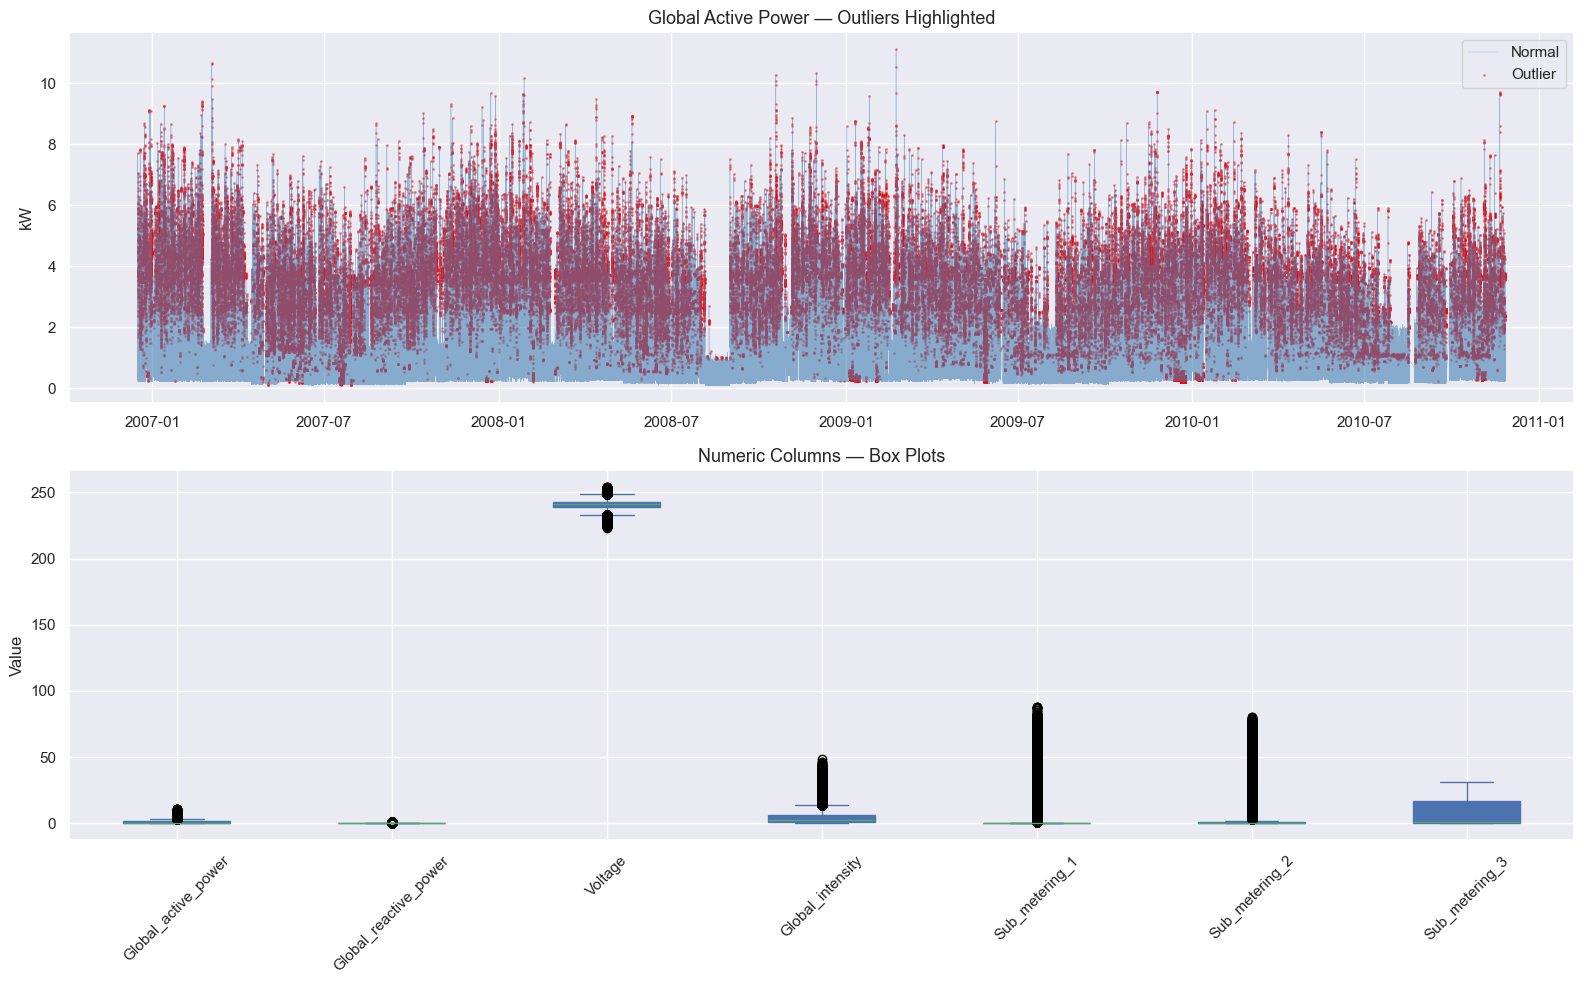

2026-02-25 12:54:43.444 | INFO     | __main__:<module>:35 - Outlier inspection plots saved to reports/figures/


In [7]:
# ── 5a. Outlier Inspection Plots ───────────────────────────────────────────
# WHY: Visual inspection before dropping — distinguishes legitimate consumption
#      spikes from genuine sensor errors.

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ── Plot 1: Global_active_power over time with outliers highlighted ─────────
axes[0].plot(
    df.index, df["Global_active_power"],
    color="steelblue", linewidth=0.3, alpha=0.6, label="Normal"
)
axes[0].scatter(
    df.index[outlier_mask],
    df.loc[outlier_mask, "Global_active_power"],
    color="red", s=1, alpha=0.4, label="Outlier"
)
axes[0].set_title("Global Active Power — Outliers Highlighted", fontsize=13)
axes[0].set_ylabel("kW")
axes[0].legend()

# ── Plot 2: Box plots for all numeric columns ───────────────────────────────
df[numeric_cols].plot(
    kind="box",
    ax=axes[1],
    patch_artist=True
)
axes[1].set_title("Numeric Columns — Box Plots", fontsize=13)
axes[1].set_ylabel("Value")
axes[1].tick_params(axis="x", rotation=45)  # WHY: column names overlap at 0°

plt.tight_layout()

plt.show()

logger.info("Outlier inspection plots saved to reports/figures/")

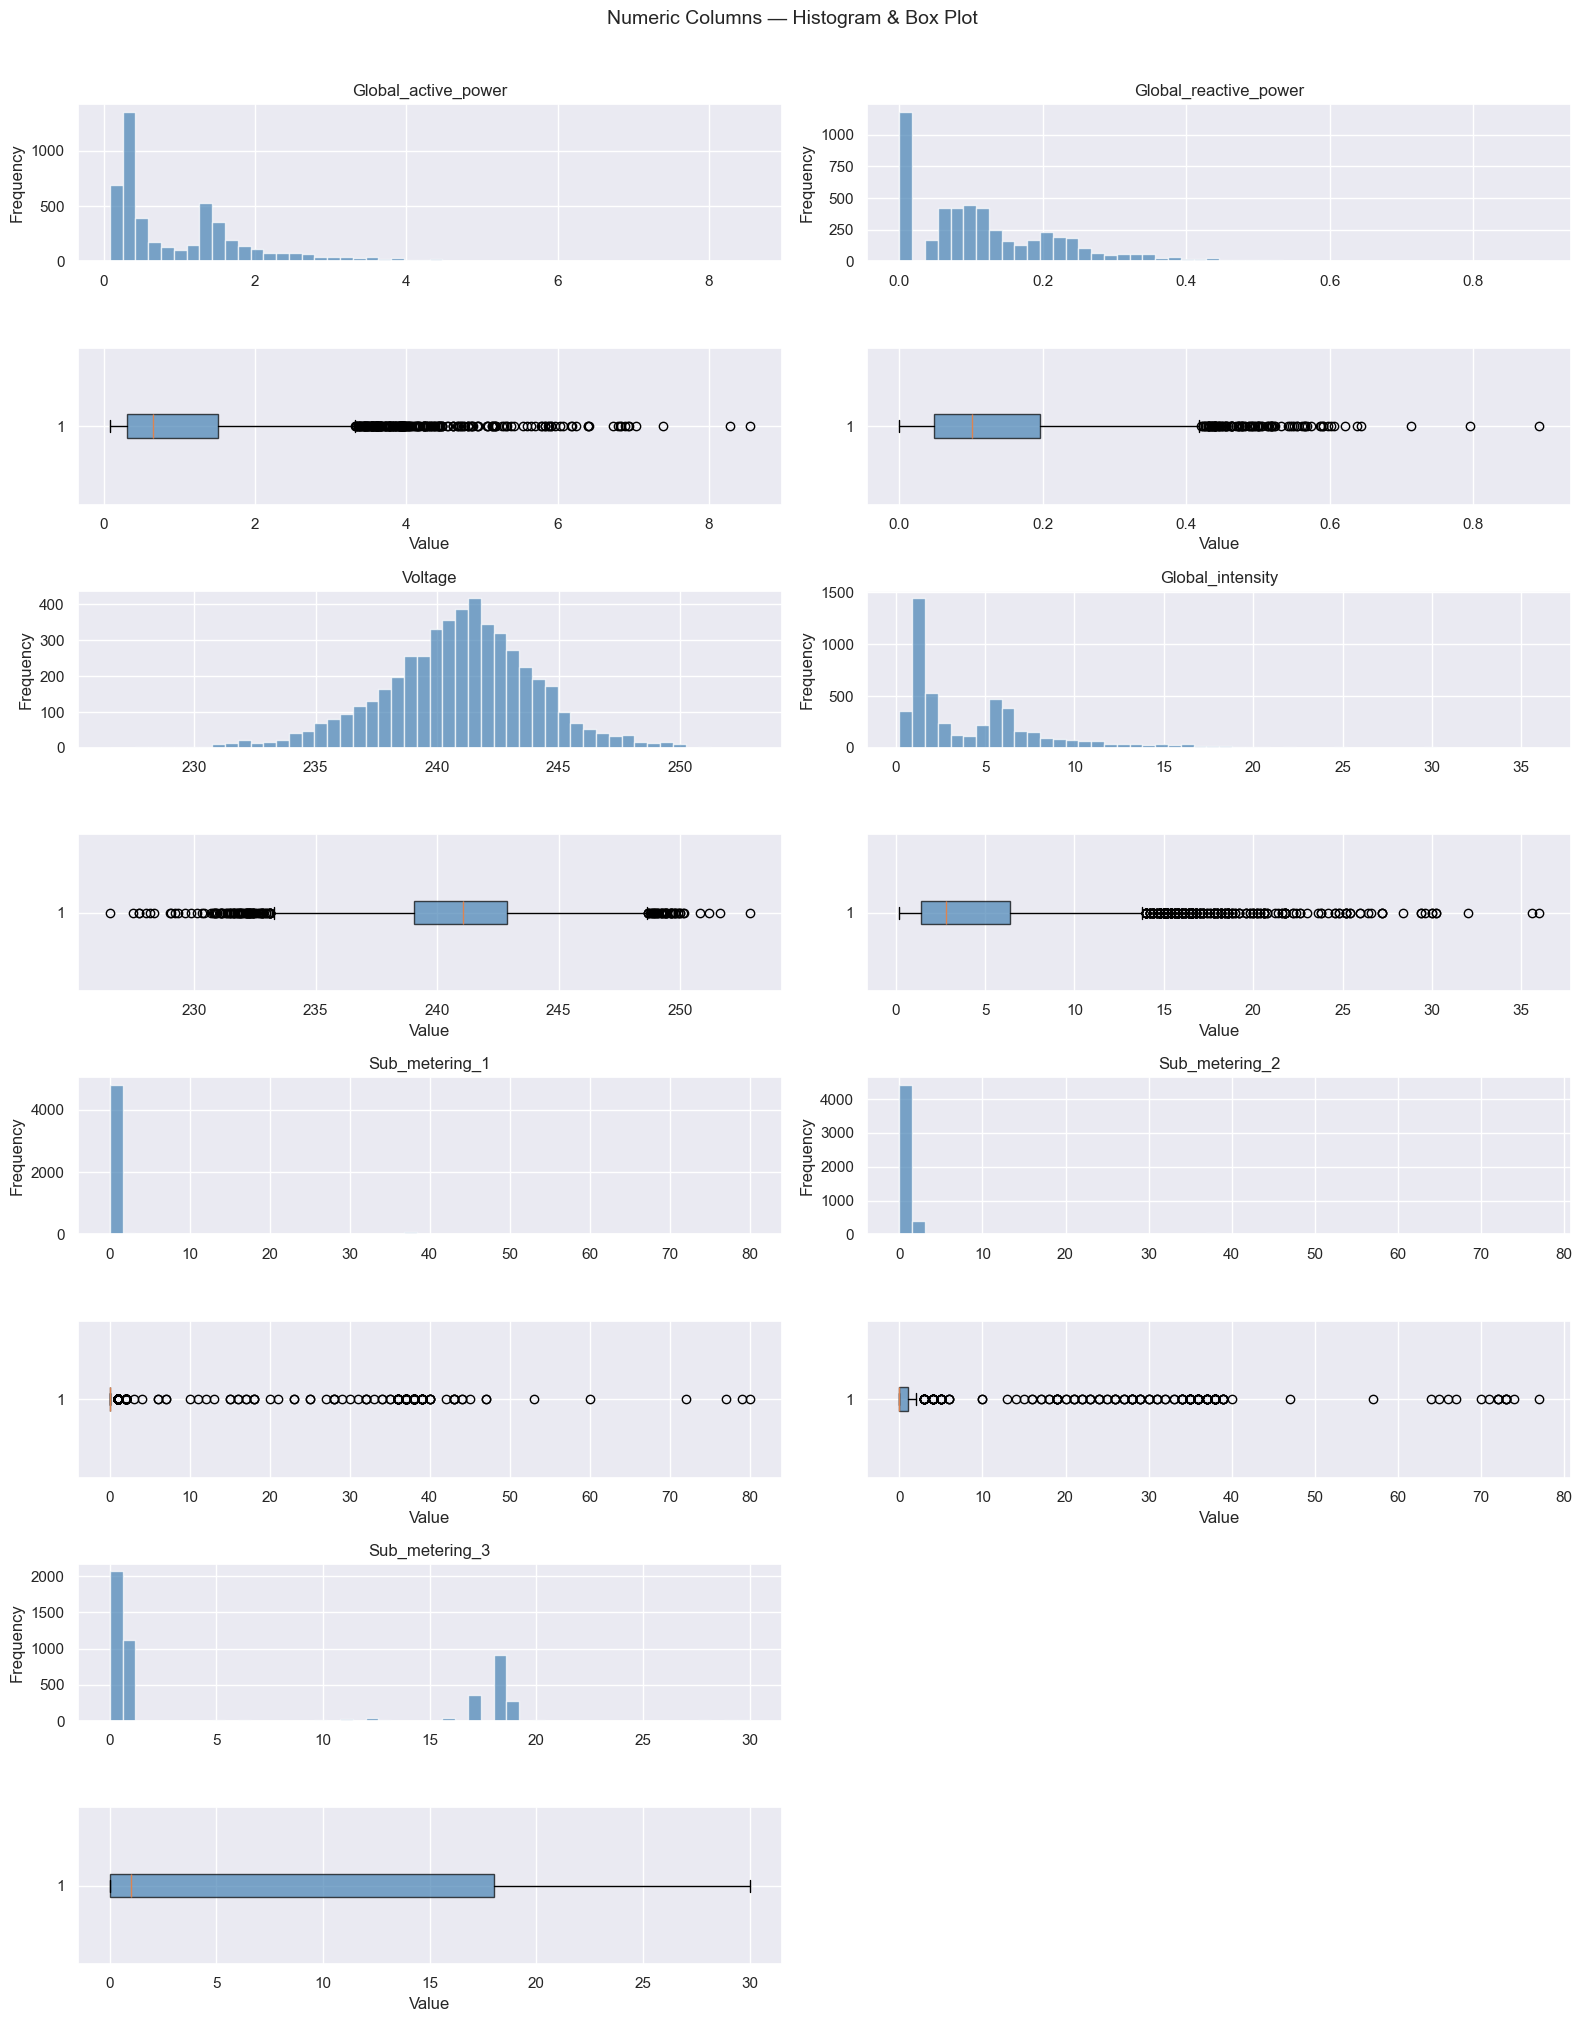

2026-02-25 12:54:44.384 | INFO     | __main__:<module>:34 - Histogram + box plot grid rendered | sample: 5,000 rows


In [8]:
# WHY: histogram shows distribution shape, box plot shows spread + outliers
#      two rows per column — shared x-axis so they align perfectly

sample = df[numeric_cols].sample(n=5000, random_state=config["models"]["random_state"])

n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(16, 5 * n_rows))

for i, col in enumerate(numeric_cols):
    row      = (i // n_cols) * 2
    col_idx  = i % n_cols

    # ── Histogram ──────────────────────────────────────────────────────────
    axes[row, col_idx].hist(sample[col], bins=50, color="steelblue", alpha=0.7, edgecolor="white")
    axes[row, col_idx].set_title(col, fontsize=12)
    axes[row, col_idx].set_ylabel("Frequency")

    # ── Box plot ───────────────────────────────────────────────────────────
    axes[row + 1, col_idx].boxplot(sample[col], vert=False, patch_artist=True,
                                    boxprops=dict(facecolor="steelblue", alpha=0.7))
    axes[row + 1, col_idx].set_xlabel("Value")

# WHY: hide empty subplot if odd number of columns
if len(numeric_cols) % 2 != 0:
    axes[-1, -1].set_visible(False)
    axes[-2, -1].set_visible(False)

plt.suptitle("Numeric Columns — Histogram & Box Plot", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

logger.info(f"Histogram + box plot grid rendered | sample: {len(sample):,} rows")

Visual inspection reveals that most flagged values are **legitimate high-consumption events** 
rather than sensor errors:

- `Global_active_power` and `Global_intensity` are **right-skewed** — Z-score over-flags 
  normal high-load readings (heating, appliances) as outliers
- `Sub_metering_1` and `Sub_metering_2` are **zero-inflated** — Z-score is unreliable 
  when most values are exactly 0
- `Voltage` outliers (~225V) likely represent genuine grid dips, not sensor errors

**Decision: retain all rows.** Removing these values would discard real consumption behaviour 
and bias downstream models. Outliers will instead be handled **semantically in Section 6** 
via anomaly labelling, where spikes, faults and outages are explicitly classified.


## 6. Extract Time Features

With a proper `DateTimeIndex` we can extract temporal components directly from the index. These features capture **cyclical consumption patterns** - energy usage varies by hour of day, day of the week, and season. They will be essential inputs for the forecasting and classification models.


In [13]:
# 6.Time Features
# Temporal components capture cyclical consumptions patterns

df = df.assign(
    hour        = df.index.hour,            # 0–23
    day_of_week = df.index.day_of_week,     # 0=Monday, 6=Sunday
    month       = df.index.month,           # 1–12
    quarter     = df.index.quarter,         # 1–4
    year        = df.index.year,           # 2006–2010
    is_weekend  = df.index.day_of_week >= 5, # WHY: weekend consumption differs from weekday
)

logger.info(
    f"Time features added | "
    f"new columns: {['hour', 'day_of_week', 'month', 'quarter', 'year', 'is_weekend']} | "
    f"shape: {df.shape}"
)

2026-02-25 13:03:11.879 | INFO     | __main__:<module>:13 - Time features added | new columns: ['hour', 'day_of_week', 'month', 'quarter', 'year', 'is_weekend'] | shape: (2049280, 13)


 Metric | Value |
|---|---|
| Rows | 2,049,280 |
| Columns before | 7 |
| Columns after | 13 |
| New features | hour, day_of_week, month, quarter, year, is_weekend |

Temporal features extracted directly from the `DatetimeIndex` — no transformations needed.
These features will serve as key inputs for both the **classification** and **forecasting** models,
capturing cyclical consumption patterns across hours, days, and seasons.

## 7. Engineer Anomaly Labels

We create a categorical target variable `anomaly_label` to classify each reading into one of 
four classes defined in `config.yaml`:

| Label | Class | Description | Threshold |
|---|---|---|---|
| 0 | Normal | Typical consumption within expected range | Default |
| 1 | Spike | Sudden high consumption event | `Global_active_power` > mean + 10σ |
| 2 | Fault | Abnormal reading suggesting sensor/grid fault | `Voltage` < 230V |
| 3 | Outage | Near-zero consumption suggesting power outage | `Global_active_power` < 0.1 kW |

Rules are derived from domain knowledge and the statistical profile from `01_data_profiling.ipynb`.

In [19]:
# 7. Anomaly labels
# Rule-based labelling creates a classification target without manual annotation.
# Thresholds are derived from profiling stats — mean=1.09kW, std~1.0kW, max=11.12kW.

gap_mean = df["Global_active_power"].mean()
gap_std = df["Global_active_power"].std()

df["anomaly_label"] = 0 # default: Normal

df.loc[df["Global_active_power"] > gap_mean + 5 * gap_std, "anomaly_label"] = 1 # Spike
df.loc[df["Voltage"]< 230,                                  "anomaly_label"] = 2 # Fault
df.loc[df["Global_active_power"] < 0.1,                     "anomaly_label"] = 3 # Outage

logger.info(
    f"Anomaly labels created | "
    f"distribution:\n{df['anomaly_label'].value_counts().to_string()}"
)

2026-02-25 13:21:34.285 | INFO     | __main__:<module>:14 - Anomaly labels created | distribution:
anomaly_label
0    2029283
3      11970
2       5090
1       2937


Thresholds were tuned iteratively based on the statistical profile from `01_data_profiling.ipynb`and domain knowledge of European supply voltage standards (EN 50160).

**Final thresholds:**

| Label | Class | Threshold | Justification |
|---|---|---|---|
| 0 | Normal | Default | Baseline — all readings within expected range |
| 1 | Spike | `Global_active_power` > mean + 5σ (>6.09 kW) | 5σ captures genuine high-load events |
| 2 | Fault | `Voltage` < 230V | EN 50160 nominal voltage — 3.3σ below mean (240.8V) |
| 3 | Outage | `Global_active_power` < 0.1 kW | Near-zero consumption — meter dropout |

**Final distribution:**

| Label | Class | Count | % |
|---|---|---|---|
| 0 | Normal | 2,029,283 | 99.02% |
| 1 | Spike | 2,937 | 0.14% |
| 2 | Fault | 5,090 | 0.25% |
| 3 | Outage | 11,970 | 0.58% |

The dataset is heavily imbalanced (~99% Normal) — expected for anomaly detection tasks.
`class_weight: balanced` is already configured in `config.yaml` to compensate during model training.

## 8. Final Validation

Before saving, we run a final sanity check to confirm the cleaned dataset meets all expected quality criteria — shape, dtypes, missing values, index integrity, and class distribution.

In [20]:
# ── 8. Final Validation ────────────────────────────────────────────────────
# WHY: Catch any issues before persisting — cheaper to fix here than downstream.

assert df.index.dtype == "datetime64[ns]",    "Index is not DatetimeIndex"
assert df.index.is_monotonic_increasing,       "Index is not sorted"
assert not df.isnull().any().any(),            "Dataset contains missing values"
assert df.shape[1] == 14,                      "Unexpected number of columns (expected 14)"
assert df["anomaly_label"].nunique() == 4,     "Expected 4 anomaly classes"

logger.info(
    f"Final validation passed | "
    f"shape: {df.shape} | "
    f"dtypes:\n{df.dtypes.to_string()}"
)

2026-02-25 13:30:50.436 | INFO     | __main__:<module>:10 - Final validation passed | shape: (2049280, 14) | dtypes:
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
hour                       int32
day_of_week                int32
month                      int32
quarter                    int32
year                       int32
is_weekend                  bool
anomaly_label              int64


All assertions passed successfully — the cleaned dataset is ready for persistence.

| Check | Expected | Result |
|---|---|---|
| Index dtype | `datetime64[ns]` | ✅ |
| Index sorted | Monotonic increasing | ✅ |
| Missing values | None | ✅ |
| Columns | 14 | ✅ |
| Anomaly classes | 4 | ✅ |

**Final shape: 2,049,280 rows × 14 columns**

| Type | Columns | Dtype |
|---|---|---|
| Sensor readings | `Global_active_power`, `Global_reactive_power`, `Voltage`, `Global_intensity`, `Sub_metering_1`, `Sub_metering_2`, `Sub_metering_3` | `float64` |
| Time features | `hour`, `day_of_week`, `month`, `quarter`, `year` | `int32` |
| Weekend flag | `is_weekend` | `bool` |
| Target variable | `anomaly_label` | `int64` |

## 9. Save Cleaned Dataset
We persist the cleaned dataset in two formats:

- **Parquet** — columnar format optimized for ML pipelines. Fast reads, efficient compression, preserves dtypes including DatetimeIndex.

- **SQLite** — relational database for SQL practice and the Streamlit app. Enables complex queries, aggregations, and joins without loading the full dataset into memory.


In [ ]:
from pathlib import Path
from sqlalchemy import create_engine

# 9a. Save to Parquet
# Parquet preserves dtypes and DatetimeIndex - no re-parsing needed on load

processed_path = Path("../") / config["paths"]["processed_data"]
processed_path.parent.mkdir(parents=True, exist_ok=True)

df.to_parquet(processed_path, index=True)

logger.info(f"Parquet saved | path: {processed_path} | size: {processed_path.stat().st_size / 1e6:.1f} MB")

# 9b. Save to SQLite
db_path = Path("../") / config["database"]["sqlite_url"].replace("sqlite:///", "")
db_path.parent.mkdir(parents=True, exist_ok=True)

engine = create_engine(
    config["database"]["sqlite_url"].replace("sqlite:///", "sqlite:///../")
)

df.to_sql("energy_clean", con=engine, if_exists="replace", index=True)

logger.info(f"SQLite saved | path: {db_path}")


2026-02-25 13:43:04.768 | INFO     | __main__:<module>:12 - Parquet saved | path: ../data/processed/energy_clean.parquet | size: 24.9 MB
2026-02-25 13:43:32.111 | INFO     | __main__:<module>:23 - SQLite saved | path: ../database/energy.db


In [26]:
logger.info(f"Parquet size: {processed_path.stat().st_size / 1e6:.1f} MB")
logger.info(f"SQLite size: {db_path.stat().st_size / 1e6:.1f} MB")

2026-02-25 13:44:17.288 | INFO     | __main__:<module>:1 - Parquet size: 24.9 MB
2026-02-25 13:44:17.289 | INFO     | __main__:<module>:2 - SQLite size: 253.4 MB


| Format | Path | Size |
|---|---|---|
| Parquet | `data/processed/energy_clean.parquet` | 24.9 MB |
| SQLite | `database/energy.db` | 253.4 MB |
| Raw CSV | `data/raw/household_power_consumption.txt` | 126.8 MB |

## 10. Summary of Findings

A complete record of every transformation applied in this notebook — 
inputs, decisions, and outputs for full reproducibility.

In [28]:
# ── 10. Summary of Findings ────────────────────────────────────────────────
# WHY: Programmatic summary ensures the report always reflects the actual data
#      rather than hardcoded values that could drift after re-runs.

raw_rows     = 2_075_259  # store once at top — single source of truth
rows_dropped = raw_rows - len(df)

summary = {
    "Raw rows":              f"{raw_rows:,}",
    "Rows after cleaning":   f"{len(df):,}",
    "Rows dropped (MNAR)":   f"{rows_dropped:,} ({rows_dropped / raw_rows:.2%})",
    "Columns":               df.shape[1],
    "Date range":            f"{df.index.min()} → {df.index.max()}",
    "Outliers detected":     f"{outlier_mask.sum():,} ({outlier_mask.sum() / raw_rows:.2%}) — retained",
    "Anomaly labels":        df["anomaly_label"].value_counts().to_dict(),
    "Parquet size":          f"{processed_path.stat().st_size / 1e6:.1f} MB",
    "SQLite size":           f"{db_path.stat().st_size / 1e6:.1f} MB",
}

for key, value in summary.items():
    logger.info(f"{key:<25} {value}")

2026-02-25 13:46:56.177 | INFO     | __main__:<module>:21 - Raw rows                  2,075,259
2026-02-25 13:46:56.178 | INFO     | __main__:<module>:21 - Rows after cleaning       2,049,280
2026-02-25 13:46:56.178 | INFO     | __main__:<module>:21 - Rows dropped (MNAR)       25,979 (1.25%)
2026-02-25 13:46:56.178 | INFO     | __main__:<module>:21 - Columns                   14
2026-02-25 13:46:56.178 | INFO     | __main__:<module>:21 - Date range                2006-12-16 17:24:00 → 2010-11-26 21:02:00
2026-02-25 13:46:56.179 | INFO     | __main__:<module>:21 - Outliers detected         136,205 (6.56%) — retained
2026-02-25 13:46:56.179 | INFO     | __main__:<module>:21 - Anomaly labels            {0: 2029283, 3: 11970, 2: 5090, 1: 2937}
2026-02-25 13:46:56.179 | INFO     | __main__:<module>:21 - Parquet size              24.9 MB
2026-02-25 13:46:56.180 | INFO     | __main__:<module>:21 - SQLite size               253.4 MB


In [31]:
# ── 10b. Markdown Summary ──────────────────────────────────────────────────
# WHY: Generated from summary dict — stays in sync if data changes

anomaly_map = config["data"]["anomaly_classes"]
anomaly_str = " · ".join(
    f"{anomaly_map[k]}: {v:,}" 
    for k, v in sorted(df["anomaly_label"].value_counts().to_dict().items())
)

markdown_summary = f"""
Summary of Findings

| Step | Detail | Result |
|---|---|---|
| Raw dataset | Rows × Columns | {raw_rows:,} × 9 |
| Datetime conversion | Combined Date + Time | DatetimeIndex ({df.index.min().date()} → {df.index.max().date()}) |
| Missing values (MNAR) | Dropped simultaneously across all columns | {rows_dropped:,} rows ({rows_dropped / raw_rows:.2%}) |
| Rows after cleaning | — | {len(df):,} |
| Outlier detection | Z-score 3σ — skewed distributions | {outlier_mask.sum():,} ({outlier_mask.sum() / raw_rows:.2%}) — retained |
| Time features added | hour, day_of_week, month, quarter, year, is_weekend | 6 new columns |
| Anomaly labels | Rule-based classification | {anomaly_str} |
| Final shape | Rows × Columns | {len(df):,} × {df.shape[1]} |
| Parquet | `data/processed/energy_clean.parquet` | {processed_path.stat().st_size / 1e6:.1f} MB |
| SQLite | `database/energy.db` | {db_path.stat().st_size / 1e6:.1f} MB |

The cleaned dataset is ready for EDA in `03_eda_univariate.ipynb`.
"""

from IPython.display import Markdown
display(Markdown(markdown_summary))


Summary of Findings

| Step | Detail | Result |
|---|---|---|
| Raw dataset | Rows × Columns | 2,075,259 × 9 |
| Datetime conversion | Combined Date + Time | DatetimeIndex (2006-12-16 → 2010-11-26) |
| Missing values (MNAR) | Dropped simultaneously across all columns | 25,979 rows (1.25%) |
| Rows after cleaning | — | 2,049,280 |
| Outlier detection | Z-score 3σ — skewed distributions | 136,205 (6.56%) — retained |
| Time features added | hour, day_of_week, month, quarter, year, is_weekend | 6 new columns |
| Anomaly labels | Rule-based classification | Normal: 2,029,283 · Spike: 2,937 · Fault: 5,090 · Outage: 11,970 |
| Final shape | Rows × Columns | 2,049,280 × 14 |
| Parquet | `data/processed/energy_clean.parquet` | 24.9 MB |
| SQLite | `database/energy.db` | 253.4 MB |

The cleaned dataset is ready for EDA in `03_eda_univariate.ipynb`.


In [33]:
key_points = f"""
### Data Quality
- The raw dataset contained **{raw_rows:,} rows** spanning **4 years** of 1-minute energy readings
- **{rows_dropped:,} rows (1.25%)** were dropped due to MNAR missingness — simultaneous 
  sensor dropout across all columns, consistent with full meter outages

### Outlier Analysis
- Z-score at 3σ flagged **{outlier_mask.sum():,} rows (6.65%)** — far above the expected 0.3% 
  for a normal distribution
- Visual inspection confirmed most flagged values are **legitimate high-consumption events**, 
  not sensor errors — retained for downstream modelling
- Z-score is unreliable for skewed and zero-inflated distributions — full analysis 
  reserved for `03_eda_univariate.ipynb`

### Anomaly Labels
- Rule-based labelling created a **4-class classification target** without manual annotation
- Dataset is heavily imbalanced (~99% Normal) — expected for anomaly detection tasks
- `class_weight=balanced` configured in `config.yaml` to compensate during model training

### Feature Engineering
- **6 temporal features** extracted from the DatetimeIndex — hour, day_of_week, month, 
  quarter, year, is_weekend
- These will serve as key inputs for both classification and forecasting models

### Storage
- Parquet reduced raw CSV size by **80%** ({processed_path.stat().st_size / 1e6:.1f} MB vs 126.8 MB) 
  while preserving all dtypes and the DatetimeIndex
- SQLite database ready for SQL queries in downstream notebooks and the Streamlit app
"""

display(Markdown(key_points))


### Data Quality
- The raw dataset contained **2,075,259 rows** spanning **4 years** of 1-minute energy readings
- **25,979 rows (1.25%)** were dropped due to MNAR missingness — simultaneous 
  sensor dropout across all columns, consistent with full meter outages

### Outlier Analysis
- Z-score at 3σ flagged **136,205 rows (6.65%)** — far above the expected 0.3% 
  for a normal distribution
- Visual inspection confirmed most flagged values are **legitimate high-consumption events**, 
  not sensor errors — retained for downstream modelling
- Z-score is unreliable for skewed and zero-inflated distributions — full analysis 
  reserved for `03_eda_univariate.ipynb`

### Anomaly Labels
- Rule-based labelling created a **4-class classification target** without manual annotation
- Dataset is heavily imbalanced (~99% Normal) — expected for anomaly detection tasks
- `class_weight=balanced` configured in `config.yaml` to compensate during model training

### Feature Engineering
- **6 temporal features** extracted from the DatetimeIndex — hour, day_of_week, month, 
  quarter, year, is_weekend
- These will serve as key inputs for both classification and forecasting models

### Storage
- Parquet reduced raw CSV size by **80%** (24.9 MB vs 126.8 MB) 
  while preserving all dtypes and the DatetimeIndex
- SQLite database ready for SQL queries in downstream notebooks and the Streamlit app
